In [1]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# load image patch arrays
print("loading stored image patches ")        
x_train_sim = np.load("x_train_sim.npy")
y_train_sim = np.load("y_train_sim.npy")
x_test_sim = np.load("x_test_sim.npy")
y_test_sim = np.load("y_test_sim.npy")

loading stored image patches 


figure plotted
figure plotted
Input Shape of the models (13318, 128, 128, 1)
Input Shape of the weights (1000, 128, 128, 1)


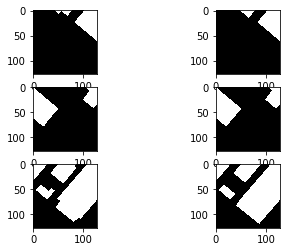

In [10]:
def show_examples(x_train_sim, y_train_sim):
    
    p_size_1 = 128
    plt.subplot(321)
    plt.imshow(np.reshape(x_train_sim[0], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(322)
    plt.imshow(np.reshape(y_train_sim[0], (p_size_1,p_size_1)),cmap=plt.cm.gray)

    plt.subplot(323)
    plt.imshow(np.reshape(x_train_sim[1], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(324)
    plt.imshow(np.reshape(y_train_sim[1], (p_size_1,p_size_1)),cmap=plt.cm.gray)    

    print("figure plotted")

    plt.subplot(325)
    plt.imshow(np.reshape(x_train_sim[2], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(326)
    plt.imshow(np.reshape(y_train_sim[2], (p_size_1,p_size_1)),cmap=plt.cm.gray)    

    print("figure plotted")
        
    input_shape1 = (None, None, 1) #x_train_sim[0].shape
    print('Input Shape of the models',  x_train_sim.shape)
    print('Input Shape of the weights', y_test_sim.shape)
    

#y_train_sim = np.ones(y_train_sim.shape) - y_train_sim
show_examples(x_train_sim, y_train_sim)    

figure plotted
figure plotted
Input Shape of the models (1000, 128, 128, 1)
Input Shape of the weights (1000, 128, 128, 1)


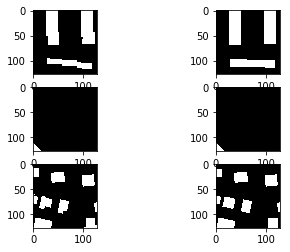

In [9]:
#y_test_sim = np.ones(y_test_sim.shape) - y_test_sim
show_examples(x_test_sim, y_test_sim)   

In [41]:
def load_batch(x_train_sim, y_train_sim, batch_size=2):
    total_samples = len(x_train_sim)
    ids = np.arange(total_samples)
    np.random.shuffle(ids)
    n_batches = int(total_samples / batch_size)
    for i in range(n_batches-1):
        batch_idx = ids[i*batch_size:(i+1)*batch_size]
        imgs_A = x_train_sim[batch_idx]
        imgs_B = y_train_sim[batch_idx]
        yield imgs_B, imgs_A     
        
def load_data(x_test_sim, y_test_sim, batch_size=1):
    return x_test_sim  

In [20]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'mapgen'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            #u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        
        d4 = Dropout(0.1)(d4)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=3, strides=1, padding='same', activation='sigmoid')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        total_samples = len(x_train_sim)
        ids = np.arange(total_samples)
        np.random.shuffle(ids)
        n_batches = int(total_samples / batch_size)
        
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(x_train_sim, y_train_sim, batch_size)):
            #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                
                # Plot the progress
                if batch_i % 20 == 0:
                    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                            % ( epoch, epochs,
                                                                                batch_i, n_batches,
                                                                                d_loss[0], 100*d_loss[1],
                                                                                g_loss[0],
                                                                                np.mean(g_loss[1:3]),
                                                                                np.mean(g_loss[3:5]),
                                                                                np.mean(g_loss[5:6]),
                                                                                elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3 # Original at github
        p_size_1 = 128
        
        imgs_A = x_test_sim[[2]]
        imgs_B = y_test_sim[[2]]

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                gen = np.reshape(gen_imgs[cnt], (p_size_1,p_size_1))
                axs[i,j].imshow(gen)
                
                #axs[i,j].imshow(gen_imgs[cnt])
                
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i), 
                    format='png', transparent=True, dpi=300)
        plt.close()

In [25]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

class DiscoGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'mapgen_disco'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Objectives
        # + Adversarial: Fool domain discriminators
        # + Translation: Minimize MAE between e.g. fake B and true B
        # + Cycle-consistency: Minimize MAE between reconstructed images and original
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        fake_B, fake_A,
                                        reconstr_A, reconstr_B ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, normalize=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalize:
                d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, normalize=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1,
                            padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        total_samples = len(x_train_sim)
        ids = np.arange(total_samples)
        np.random.shuffle(ids)
        n_batches = int(total_samples / batch_size)
        
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(x_train_sim, y_train_sim, batch_size)):
        
        #for epoch in range(epochs):

            #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, \
                                                                         imgs_B, imgs_A, \
                                                                         imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time
                
                # Plot the progress
                if batch_i % 20 == 0:
                    # Plot the progress
                    print ("[%d] [%d/%d] time: %s, [d_loss: %f, g_loss: %f]" % (epoch, batch_i,
                                                                            n_batches,
                                                                            elapsed_time,
                                                                            d_loss[0], g_loss[0]))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3 # Original at github
        p_size_1 = 128
        
        imgs_A = x_test_sim[[2]]
        imgs_B = y_test_sim[[2]]

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                gen = np.reshape(gen_imgs[cnt], (p_size_1,p_size_1))
                axs[i,j].imshow(gen)
                
                #axs[i,j].imshow(gen_imgs[cnt])
                
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i), 
                    format='png', transparent=True, dpi=300)
        plt.close()

In [52]:
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'mapgen_pix2pix'
        #self.data_loader = DataLoader(dataset_name=self.dataset_name,
        #                              img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        total_samples = len(x_train_sim)
        ids = np.arange(total_samples)
        np.random.shuffle(ids)
        n_batches = int(total_samples / batch_size)
        
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(x_train_sim, y_train_sim, batch_size)):
                
        #for epoch in range(epochs):
        #    for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
                # Plot the progress
                if batch_i % 20 == 0:
                    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                            batch_i, n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)


    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3
        p_size_1 = 128
        
        imgs_A = y_test_sim[[0, 2, 3]]
        imgs_B = x_test_sim[[0, 2, 3]]
        
        #imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = gan.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Generated', 'Target']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                gen = np.reshape(gen_imgs[cnt], (p_size_1,p_size_1))
                axs[i,j].imshow(gen)
                
                #axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i),
                   format='png', transparent=True, dpi=300)
        plt.close()

In [53]:
if __name__ == '__main__':
    gan = Pix2Pix()
    gan.train(epochs=20, batch_size=16, sample_interval=100)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/20] [Batch 0/832] [D loss: 7.870375, acc:  12%] [G loss: 64.371910] time: 0:00:36.721544
[Epoch 0/20] [Batch 20/832] [D loss: 0.457253, acc:  47%] [G loss: 19.006721] time: 0:00:42.103269
[Epoch 0/20] [Batch 40/832] [D loss: 0.297263, acc:  63%] [G loss: 16.023399] time: 0:00:46.835354
[Epoch 0/20] [Batch 60/832] [D loss: 0.222060, acc:  68%] [G loss: 8.699268] time: 0:00:51.529475
[Epoch 0/20] [Batch 80/832] [D loss: 0.257987, acc:  71%] [G loss: 4.944899] time: 0:00:56.192739
[Epoch 0/20] [Batch 100/832] [D loss: 0.653818, acc:  66%] [G loss: 6.067722] time: 0:01:00.918885
[Epoch 0/20] [Batch 120/832] [D loss: 0.262467, acc:  63%] [G loss: 7.106416] time: 0:01:06.273493
[Epoch 0/20] [Batch 140/832] [D loss: 0.243340, acc:  58%] [G loss: 6.153952] time: 0:01:10.990335
[Epoch 0/20] [Batch 160/832] [D loss: 0.522646, acc:  53%] [G loss: 9.050786] time: 0:01:15.688035
[Epoch 0/20] [Batch 180/832] [D loss: 0.255223, acc:  62%] [G loss: 4.654811] time: 0:01:20.370161
[Epoch 0/20] 

[Epoch 1/20] [Batch 820/832] [D loss: 0.032941, acc:  98%] [G loss: 8.059990] time: 0:07:18.298779
[Epoch 2/20] [Batch 0/832] [D loss: 0.041371, acc:  99%] [G loss: 3.240099] time: 0:07:20.933789
[Epoch 2/20] [Batch 20/832] [D loss: 0.283128, acc:  69%] [G loss: 4.786171] time: 0:07:26.368196
[Epoch 2/20] [Batch 40/832] [D loss: 0.015290, acc: 100%] [G loss: 3.611000] time: 0:07:31.157771
[Epoch 2/20] [Batch 60/832] [D loss: 0.159652, acc:  77%] [G loss: 5.683451] time: 0:07:35.936112
[Epoch 2/20] [Batch 80/832] [D loss: 0.054482, acc:  96%] [G loss: 5.780769] time: 0:07:40.703910
[Epoch 2/20] [Batch 100/832] [D loss: 0.018447, acc:  99%] [G loss: 5.948878] time: 0:07:45.468577
[Epoch 2/20] [Batch 120/832] [D loss: 0.024382, acc:  99%] [G loss: 6.815408] time: 0:07:50.828165
[Epoch 2/20] [Batch 140/832] [D loss: 0.019887, acc:  99%] [G loss: 4.957947] time: 0:07:55.538269
[Epoch 2/20] [Batch 160/832] [D loss: 0.038373, acc:  97%] [G loss: 5.940123] time: 0:08:00.283649
[Epoch 2/20] [Ba

[Epoch 3/20] [Batch 800/832] [D loss: 0.010012, acc: 100%] [G loss: 4.137491] time: 0:13:57.743838
[Epoch 3/20] [Batch 820/832] [D loss: 0.010149, acc: 100%] [G loss: 3.657351] time: 0:14:03.100263
[Epoch 4/20] [Batch 0/832] [D loss: 0.035581, acc:  99%] [G loss: 5.659532] time: 0:14:05.691258
[Epoch 4/20] [Batch 20/832] [D loss: 0.008170, acc:  99%] [G loss: 5.198228] time: 0:14:11.057699
[Epoch 4/20] [Batch 40/832] [D loss: 0.010166, acc:  99%] [G loss: 4.558654] time: 0:14:15.767561
[Epoch 4/20] [Batch 60/832] [D loss: 0.026406, acc:  99%] [G loss: 3.373536] time: 0:14:20.511153
[Epoch 4/20] [Batch 80/832] [D loss: 0.007593, acc: 100%] [G loss: 4.832661] time: 0:14:25.221030
[Epoch 4/20] [Batch 100/832] [D loss: 0.021590, acc: 100%] [G loss: 4.531067] time: 0:14:29.957492
[Epoch 4/20] [Batch 120/832] [D loss: 0.019255, acc: 100%] [G loss: 4.816875] time: 0:14:35.341329
[Epoch 4/20] [Batch 140/832] [D loss: 0.013504, acc:  99%] [G loss: 4.076936] time: 0:14:40.081451
[Epoch 4/20] [Ba

[Epoch 5/20] [Batch 780/832] [D loss: 0.006110, acc:  99%] [G loss: 3.052248] time: 0:20:36.763090
[Epoch 5/20] [Batch 800/832] [D loss: 0.006901, acc:  99%] [G loss: 4.422963] time: 0:20:41.473704
[Epoch 5/20] [Batch 820/832] [D loss: 0.005314, acc:  99%] [G loss: 3.959533] time: 0:20:46.788913
[Epoch 6/20] [Batch 0/832] [D loss: 0.006431, acc:  99%] [G loss: 3.503030] time: 0:20:49.380042
[Epoch 6/20] [Batch 20/832] [D loss: 0.010254, acc:  99%] [G loss: 3.949857] time: 0:20:54.784208
[Epoch 6/20] [Batch 40/832] [D loss: 0.006324, acc: 100%] [G loss: 4.316365] time: 0:20:59.520778
[Epoch 6/20] [Batch 60/832] [D loss: 0.004712, acc:  99%] [G loss: 3.392971] time: 0:21:04.259961
[Epoch 6/20] [Batch 80/832] [D loss: 0.015568, acc:  99%] [G loss: 5.106857] time: 0:21:08.995144
[Epoch 6/20] [Batch 100/832] [D loss: 0.014506, acc:  99%] [G loss: 4.222776] time: 0:21:13.725835
[Epoch 6/20] [Batch 120/832] [D loss: 0.009827, acc:  99%] [G loss: 4.503709] time: 0:21:19.043881
[Epoch 6/20] [Ba

[Epoch 7/20] [Batch 760/832] [D loss: 0.003381, acc: 100%] [G loss: 3.933330] time: 0:27:15.651760
[Epoch 7/20] [Batch 780/832] [D loss: 0.002698, acc: 100%] [G loss: 4.430490] time: 0:27:20.373575
[Epoch 7/20] [Batch 800/832] [D loss: 0.002439, acc: 100%] [G loss: 3.982880] time: 0:27:25.091327
[Epoch 7/20] [Batch 820/832] [D loss: 0.002587, acc: 100%] [G loss: 3.881551] time: 0:27:30.443008
[Epoch 8/20] [Batch 0/832] [D loss: 0.002563, acc: 100%] [G loss: 3.508863] time: 0:27:33.027604
[Epoch 8/20] [Batch 20/832] [D loss: 0.002016, acc: 100%] [G loss: 3.671824] time: 0:27:38.340401
[Epoch 8/20] [Batch 40/832] [D loss: 0.002461, acc: 100%] [G loss: 3.341746] time: 0:27:43.069480
[Epoch 8/20] [Batch 60/832] [D loss: 0.031147, acc:  97%] [G loss: 3.989508] time: 0:27:47.787833
[Epoch 8/20] [Batch 80/832] [D loss: 0.009036, acc:  99%] [G loss: 3.970236] time: 0:27:52.518633
[Epoch 8/20] [Batch 100/832] [D loss: 0.013775, acc:  99%] [G loss: 3.636239] time: 0:27:57.228543
[Epoch 8/20] [Ba

[Epoch 9/20] [Batch 740/832] [D loss: 0.013383, acc:  99%] [G loss: 4.639285] time: 0:33:53.945324
[Epoch 9/20] [Batch 760/832] [D loss: 0.028380, acc:  98%] [G loss: 3.668562] time: 0:33:58.665336
[Epoch 9/20] [Batch 780/832] [D loss: 0.005740, acc:  99%] [G loss: 3.075785] time: 0:34:03.376485
[Epoch 9/20] [Batch 800/832] [D loss: 0.006434, acc:  99%] [G loss: 3.677903] time: 0:34:08.083058
[Epoch 9/20] [Batch 820/832] [D loss: 0.002321, acc:  99%] [G loss: 3.977887] time: 0:34:13.458061
[Epoch 10/20] [Batch 0/832] [D loss: 0.005673, acc:  99%] [G loss: 4.196154] time: 0:34:16.046916
[Epoch 10/20] [Batch 20/832] [D loss: 0.004793, acc:  99%] [G loss: 3.909562] time: 0:34:21.366630
[Epoch 10/20] [Batch 40/832] [D loss: 0.005211, acc:  99%] [G loss: 2.455539] time: 0:34:26.085068
[Epoch 10/20] [Batch 60/832] [D loss: 0.017130, acc:  98%] [G loss: 3.237546] time: 0:34:30.798730
[Epoch 10/20] [Batch 80/832] [D loss: 0.015598, acc:  99%] [G loss: 3.674239] time: 0:34:35.515805
[Epoch 10/2

[Epoch 11/20] [Batch 720/832] [D loss: 0.004404, acc:  99%] [G loss: 3.780509] time: 0:40:35.809456
[Epoch 11/20] [Batch 740/832] [D loss: 0.002198, acc: 100%] [G loss: 3.492057] time: 0:40:40.536445
[Epoch 11/20] [Batch 760/832] [D loss: 0.002117, acc: 100%] [G loss: 4.118449] time: 0:40:45.253326
[Epoch 11/20] [Batch 780/832] [D loss: 0.005650, acc:  99%] [G loss: 3.027246] time: 0:40:49.961894
[Epoch 11/20] [Batch 800/832] [D loss: 0.001469, acc: 100%] [G loss: 3.187466] time: 0:40:54.694862
[Epoch 11/20] [Batch 820/832] [D loss: 0.004519, acc: 100%] [G loss: 2.992311] time: 0:41:00.076636
[Epoch 12/20] [Batch 0/832] [D loss: 0.004970, acc: 100%] [G loss: 2.459819] time: 0:41:02.666633
[Epoch 12/20] [Batch 20/832] [D loss: 0.003015, acc: 100%] [G loss: 4.533289] time: 0:41:08.048214
[Epoch 12/20] [Batch 40/832] [D loss: 0.003176, acc:  99%] [G loss: 3.576066] time: 0:41:12.785325
[Epoch 12/20] [Batch 60/832] [D loss: 0.008419, acc:  99%] [G loss: 3.375981] time: 0:41:17.498174
[Epoc

[Epoch 13/20] [Batch 700/832] [D loss: 0.007497, acc:  99%] [G loss: 3.638604] time: 0:47:13.967507
[Epoch 13/20] [Batch 720/832] [D loss: 0.005573, acc:  99%] [G loss: 3.278771] time: 0:47:19.313875
[Epoch 13/20] [Batch 740/832] [D loss: 0.004512, acc: 100%] [G loss: 4.873507] time: 0:47:24.023750
[Epoch 13/20] [Batch 760/832] [D loss: 0.007524, acc:  99%] [G loss: 2.838946] time: 0:47:28.751310
[Epoch 13/20] [Batch 780/832] [D loss: 0.005547, acc:  99%] [G loss: 4.185836] time: 0:47:33.458706
[Epoch 13/20] [Batch 800/832] [D loss: 0.005071, acc: 100%] [G loss: 2.608414] time: 0:47:38.144537
[Epoch 13/20] [Batch 820/832] [D loss: 0.002905, acc:  99%] [G loss: 2.903435] time: 0:47:43.493455
[Epoch 14/20] [Batch 0/832] [D loss: 0.001027, acc: 100%] [G loss: 3.469868] time: 0:47:46.080823
[Epoch 14/20] [Batch 20/832] [D loss: 0.007155, acc:  99%] [G loss: 3.256444] time: 0:47:51.464074
[Epoch 14/20] [Batch 40/832] [D loss: 0.002720, acc:  99%] [G loss: 2.781024] time: 0:47:56.179000
[Epo

[Epoch 15/20] [Batch 680/832] [D loss: 0.002417, acc: 100%] [G loss: 2.989161] time: 0:53:54.359690
[Epoch 15/20] [Batch 700/832] [D loss: 0.002936, acc:  99%] [G loss: 3.472717] time: 0:53:59.046653
[Epoch 15/20] [Batch 720/832] [D loss: 0.003217, acc: 100%] [G loss: 3.175897] time: 0:54:04.499460
[Epoch 15/20] [Batch 740/832] [D loss: 0.005912, acc:  99%] [G loss: 4.067271] time: 0:54:09.225936
[Epoch 15/20] [Batch 760/832] [D loss: 0.002970, acc:  99%] [G loss: 3.165312] time: 0:54:13.935528
[Epoch 15/20] [Batch 780/832] [D loss: 0.001643, acc:  99%] [G loss: 3.280716] time: 0:54:18.631212
[Epoch 15/20] [Batch 800/832] [D loss: 0.002914, acc:  99%] [G loss: 2.818940] time: 0:54:23.333709
[Epoch 15/20] [Batch 820/832] [D loss: 0.003080, acc:  99%] [G loss: 2.986535] time: 0:54:28.879311
[Epoch 16/20] [Batch 0/832] [D loss: 0.002242, acc: 100%] [G loss: 4.703721] time: 0:54:31.466167
[Epoch 16/20] [Batch 20/832] [D loss: 0.001225, acc: 100%] [G loss: 2.700352] time: 0:54:37.249778
[Ep

[Epoch 17/20] [Batch 660/832] [D loss: 0.001888, acc: 100%] [G loss: 4.038249] time: 1:00:37.314821
[Epoch 17/20] [Batch 680/832] [D loss: 0.001168, acc: 100%] [G loss: 3.376439] time: 1:00:42.035451
[Epoch 17/20] [Batch 700/832] [D loss: 0.000838, acc: 100%] [G loss: 3.573323] time: 1:00:46.749463
[Epoch 17/20] [Batch 720/832] [D loss: 0.001644, acc: 100%] [G loss: 4.166298] time: 1:00:52.284261
[Epoch 17/20] [Batch 740/832] [D loss: 0.000640, acc: 100%] [G loss: 2.572508] time: 1:00:57.002091
[Epoch 17/20] [Batch 760/832] [D loss: 0.000869, acc: 100%] [G loss: 4.059485] time: 1:01:01.703792
[Epoch 17/20] [Batch 780/832] [D loss: 0.001187, acc: 100%] [G loss: 2.625669] time: 1:01:06.410498
[Epoch 17/20] [Batch 800/832] [D loss: 0.000730, acc: 100%] [G loss: 3.644705] time: 1:01:11.132732
[Epoch 17/20] [Batch 820/832] [D loss: 0.001679, acc: 100%] [G loss: 3.448162] time: 1:01:16.469384
[Epoch 18/20] [Batch 0/832] [D loss: 0.005068, acc: 100%] [G loss: 2.253225] time: 1:01:19.076776
[E

[Epoch 19/20] [Batch 640/832] [D loss: 0.000806, acc: 100%] [G loss: 3.278689] time: 1:07:18.558599
[Epoch 19/20] [Batch 660/832] [D loss: 0.010385, acc:  99%] [G loss: 3.145500] time: 1:07:23.246175
[Epoch 19/20] [Batch 680/832] [D loss: 0.001061, acc: 100%] [G loss: 3.598850] time: 1:07:27.946940
[Epoch 19/20] [Batch 700/832] [D loss: 0.000868, acc: 100%] [G loss: 2.938743] time: 1:07:32.671395
[Epoch 19/20] [Batch 720/832] [D loss: 0.001234, acc: 100%] [G loss: 3.445480] time: 1:07:38.022643
[Epoch 19/20] [Batch 740/832] [D loss: 0.000806, acc: 100%] [G loss: 3.313713] time: 1:07:42.722030
[Epoch 19/20] [Batch 760/832] [D loss: 0.005767, acc: 100%] [G loss: 2.794884] time: 1:07:47.441554
[Epoch 19/20] [Batch 780/832] [D loss: 0.003647, acc: 100%] [G loss: 2.560962] time: 1:07:52.173570
[Epoch 19/20] [Batch 800/832] [D loss: 0.000791, acc: 100%] [G loss: 3.443842] time: 1:07:56.879906
[Epoch 19/20] [Batch 820/832] [D loss: 0.000839, acc: 100%] [G loss: 2.700754] time: 1:08:02.709057


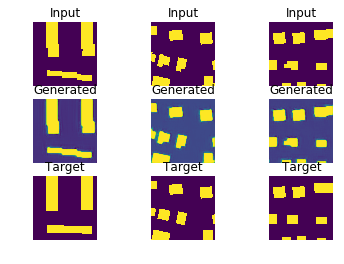

In [45]:
if 1:
        r, c = 3, 3
        p_size_1 = 128
        
        imgs_A = y_test_sim[[0, 2, 3]]
        imgs_B = x_test_sim[[0, 2, 3]]
        
        #imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = gan.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Generated', 'Target']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                gen = np.reshape(gen_imgs[cnt], (p_size_1,p_size_1))
                axs[i,j].imshow(gen)
                
                #axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1

In [37]:
gen_imgs.shape

(9, 128, 128, 1)

In [ ]:
r, c = 2, 3 # Original at github
imgs_A = x_test_sim[[2]]
imgs_B = y_test_sim[[2]]
p_size_1 = 128
if 1:
        # Translate images to the other domain
        fake_B = gan.g_AB.predict(imgs_A)
        fake_A = gan.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = gan.g_BA.predict(fake_B)
        reconstr_B = gan.g_AB.predict(fake_A)
        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                gen = np.reshape(gen_imgs[cnt], (p_size_1,p_size_1))
                axs[i,j].imshow(gen)
                axs[i,j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1

In [ ]:
np.max(reconstr_B), np.min(reconstr_B)

In [ ]:
np.max(fake_B), np.min(fake_B)